# Milestone 1 - Relation Classification Baseline

## Load dataset

In [1]:
import pandas as pd
from pathlib import Path

# Load FoodDisease dataset
usecols = ['food_entity', 'disease_entity', 'sentence', 'is_cause', 'is_treat']
df = pd.read_csv(
    Path('..', 'data', 'food_disease.csv'),
    sep=',', quotechar='"',
    skipinitialspace=True,
    encoding='utf-8',
    on_bad_lines='skip',
    usecols=usecols)

print(f"Number of docs: {len(df)}")
df.head()

Number of docs: 608


,food_entity,disease_entity,sentence,is_cause,is_treat
0,bombax ceiba l. (bombacaceae) fruits,urinary stones,"Interestingly, many Indian tribes use Bombax c...",0.0,1.0
1,ultra-processed food,obesity,Ultra-processed food consumption has been asso...,1.0,0.0
2,salt,osteoporosis,Salt has notoriously been blamed for causing a...,1.0,0.0
3,broiler chicken,footpad dermatitis,in broiler chicken flocks when animal-based me...,0.0,0.0
4,sfp,diabetes,"In short, this study demonstrated that SFP cou...",0.0,1.0


## Preprocessing

In [2]:
# Make case insensitive (no loss because emphasis on words does not play a role)
df['sentence'] = df['sentence'].map(lambda x: x.lower())
# Replace entities in sentence with placeholder tokens (may be useful for generalization when using n-grams)
df['sentence'] = df.apply(lambda x: x['sentence'].replace(x['food_entity'], 'food_entity'), axis=1)
df['sentence'] = df.apply(lambda x: x['sentence'].replace(x['disease_entity'], 'disease_entity'), axis=1)

for i in range(5):
    print(df['sentence'][i])

# Drop malformed documents (both entities must be present in sentence)
df = df[df['sentence'].apply(lambda x: 'food_entity' in x and 'disease_entity' in x)]
print(f"Number of docs: {len(df)}")


interestingly, many indian tribes use food_entity as a traditional medicine for the treatment of disease_entity.
food_entity consumption has been associated with several health outcomes such as disease_entity, hypertension, cardiovascular disease and cancer.
food_entity has notoriously been blamed for causing an increase in the urinary excretion of calcium, and thus is a considered a risk factor for disease_entity.
in food_entity flocks when animal-based measures related to disease_entity, hock burns, body lesions and arthritis are identified under commercial conditions (high density).
in short, this study demonstrated that food_entity could be developed as functional foods or pharmaceutical supplements for the prevention or mitigation of disease_entity and its complications.
Number of docs: 595


In [3]:
# Convert labels to right dtype
label_cols = ['is_cause', 'is_treat']
df['is_cause'] = df['is_cause'].astype(float).astype(int)
df['is_treat'] = df['is_treat'].astype(float).astype(int)
df[label_cols].head()

,is_cause,is_treat
0,0,1
1,1,0
2,1,0
3,0,0
4,0,1


In [4]:
import nltk

# Tokenize the sentences
df['tokens'] = df['sentence'].apply(lambda x: nltk.word_tokenize(x))
# Remove stop words and tokens with length smaller than 2 (i.e. punctuations)
df['tokens'] = df['tokens'].apply(lambda x: [token for token in x if token not in nltk.corpus.stopwords.words('english') and len(token) > 1])
# Perform stemming
porter = nltk.PorterStemmer()
df['tokens_stem'] = df['tokens'].apply(lambda x: [porter.stem(token) for token in x])
for i in range(5):
    print(df['tokens_stem'][i])

['interestingli', 'mani', 'indian', 'tribe', 'use', 'food_ent', 'tradit', 'medicin', 'treatment', 'disease_ent']
['food_ent', 'consumpt', 'associ', 'sever', 'health', 'outcom', 'disease_ent', 'hypertens', 'cardiovascular', 'diseas', 'cancer']
['food_ent', 'notori', 'blame', 'caus', 'increas', 'urinari', 'excret', 'calcium', 'thu', 'consid', 'risk', 'factor', 'disease_ent']
['food_ent', 'flock', 'animal-bas', 'measur', 'relat', 'disease_ent', 'hock', 'burn', 'bodi', 'lesion', 'arthriti', 'identifi', 'commerci', 'condit', 'high', 'densiti']
['short', 'studi', 'demonstr', 'food_ent', 'could', 'develop', 'function', 'food', 'pharmaceut', 'supplement', 'prevent', 'mitig', 'disease_ent', 'complic']


In [5]:
# Dependencies for WorNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Perform lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
df['tokens_lemma'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])
for i in range(5):
    print(df['tokens_lemma'][i])

['interestingly', 'many', 'indian', 'tribe', 'use', 'food_entity', 'traditional', 'medicine', 'treatment', 'disease_entity']
['food_entity', 'consumption', 'associated', 'several', 'health', 'outcome', 'disease_entity', 'hypertension', 'cardiovascular', 'disease', 'cancer']
['food_entity', 'notoriously', 'blamed', 'causing', 'increase', 'urinary', 'excretion', 'calcium', 'thus', 'considered', 'risk', 'factor', 'disease_entity']
['food_entity', 'flock', 'animal-based', 'measure', 'related', 'disease_entity', 'hock', 'burn', 'body', 'lesion', 'arthritis', 'identified', 'commercial', 'condition', 'high', 'density']
['short', 'study', 'demonstrated', 'food_entity', 'could', 'developed', 'functional', 'food', 'pharmaceutical', 'supplement', 'prevention', 'mitigation', 'disease_entity', 'complication']


## Features

### Normal features
Here the BOW is constructed from all tokens in the sentence.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess in one function, from sentence (useful but not needed, because we pass tokens from preprocessing directly)
def tokenize_sentence(sen):
    tokens = sen.lower()
    tokens = nltk.word_tokenize(tokens)
    tokens = [x for x in tokens if x not in nltk.corpus.stopwords.words('english') and len(x) > 1]
    tokens = [nltk.PorterStemmer().stem(x) for x in tokens]
    return tokens

# Vector with occurance of ngrams (ngram_range upper bound should be hyperparameter in search)
# For all options refer to https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Use identity function as tokenizer to pass tokens directly, otherwise replace with tokenize_sentence function
vectorizer = CountVectorizer(tokenizer=lambda x: x, binary=True, ngram_range=(1, 1), analyzer='word', lowercase=False)
features = vectorizer.fit_transform(df['tokens_lemma'])
features.shape

(595, 2624)

### Syntactic features

Here the BOW is constructed only from the tokens in the shortest dependency path between the entities.

c:\Users\alexs\miniconda3\envs\tuwnlpie\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sentence:
interestingly interestingly ADV RB advmod xxxx True False
, , PUNCT , punct , False False
many many ADJ JJ amod xxxx True True
indian indian ADJ JJ amod xxxx True False
tribes tribe NOUN NNS nsubj xxxx True False
use use VERB VBP ROOT xxx True False
food_entity food_entity NOUN NN dobj xxxx_xxxx False False
as as ADP IN prep xx True True
a a DET DT det x True True
traditional traditional ADJ JJ amod xxxx True False
medicine medicine NOUN NN pobj xxxx True False
for for ADP IN prep xxx True True
the the DET DT det xxx True True
treatment treatment NOUN NN pobj xxxx True False
of of ADP IN prep xx True True
disease_entity disease_entity NOUN NN pobj xxxx_xxxx False False
. . PUNCT . punct . False False
7
Shortest path: ['food_entity', 'use', 'as', 'medicine', 'for', 'treatment', 'of', 'disease_entity']


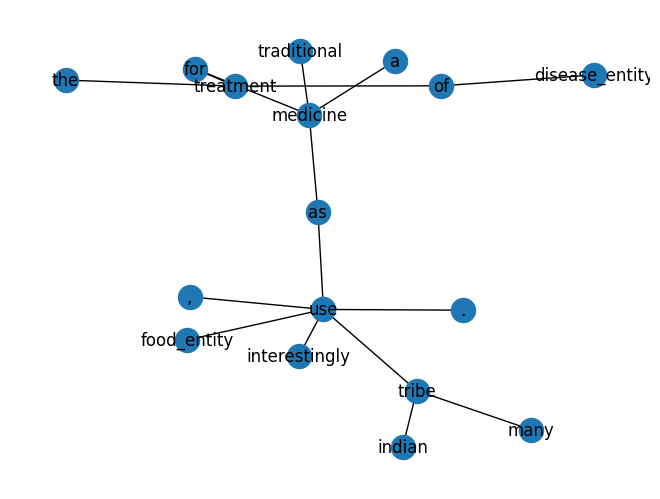

In [7]:
import spacy
import networkx as nx

nlp = spacy.load("en_core_web_sm")
    
doc = nlp(df['sentence'][0])
print('sentence:'.format(doc))

# Load spacy's dependency tree into a networkx graph
for token in doc:
    print(
        token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        token.shape_, token.is_alpha, token.is_stop)
edges = []
for token in doc:
    for child in token.children:
        edges.append((
            '{0}'.format(token.lemma_),
            '{0}'.format(child.lemma_)))
                      
graph = nx.Graph(edges)
entity1 = 'food_entity'
entity2 = 'disease_entity'

print(nx.shortest_path_length(graph, source=entity1, target=entity2))
print(f"Shortest path: {nx.shortest_path(graph, source=entity1, target=entity2)}")
nx.draw(graph, with_labels=True)

In [8]:
def shortest_dep_path(sentence):
    doc = nlp(sentence)
    edges = []
    for token in doc:
        for child in token.children:
            edges.append((
                '{0}'.format(token.lemma_),
                '{0}'.format(child.lemma_)))
    graph = nx.Graph(edges)
    entity1 = 'food_entity'
    entity2 = 'disease_entity'
    try:
        return nx.shortest_path(graph, source=entity1, target=entity2)
    except:
        return []

def remove_stop_words(tokens):
    return [x for x in tokens if x not in nltk.corpus.stopwords.words('english') and len(x) > 1]

df['sdp_tokens_lemma'] = df['sentence'].apply(lambda x: remove_stop_words(shortest_dep_path(x)))

for i in range(5):
    print(f"Index: {i}")
    print(df['sentence'][i])
    print(df['tokens_lemma'][i])
    print(df['sdp_tokens_lemma'][i])

Index: 0
interestingly, many indian tribes use food_entity as a traditional medicine for the treatment of disease_entity.
['interestingly', 'many', 'indian', 'tribe', 'use', 'food_entity', 'traditional', 'medicine', 'treatment', 'disease_entity']
['food_entity', 'use', 'medicine', 'treatment', 'disease_entity']
Index: 1
food_entity consumption has been associated with several health outcomes such as disease_entity, hypertension, cardiovascular disease and cancer.
['food_entity', 'consumption', 'associated', 'several', 'health', 'outcome', 'disease_entity', 'hypertension', 'cardiovascular', 'disease', 'cancer']
['food_entity', 'consumption', 'associate', 'outcome', 'disease_entity']
Index: 2
food_entity has notoriously been blamed for causing an increase in the urinary excretion of calcium, and thus is a considered a risk factor for disease_entity.
['food_entity', 'notoriously', 'blamed', 'causing', 'increase', 'urinary', 'excretion', 'calcium', 'thus', 'considered', 'risk', 'factor', '

In [9]:
vectorizer = CountVectorizer(tokenizer=lambda x: x, binary=True, ngram_range=(1, 1), analyzer='word', lowercase=False)
features = vectorizer.fit_transform(df['sdp_tokens_lemma'])
features.shape

(595, 505)

#### Interpretation
We can see that if we only consider the shortest path, then potential explainations may be ommitted (e.g. strong signals like 'disease'). On the other hand the vocabulary shrinks considerably (from 2624 to 505), with a distilled signal in the SDP (if the signal is not lost).

## Model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.multioutput import MultiOutputClassifier

# Split data
df_train, df_test = train_test_split(df, test_size=0.20)
# Prepare labels
y_train = df_train[label_cols].to_numpy()
y_test = df_test[label_cols].to_numpy()

### Full BOW features

In [11]:
# Prepare feature vectors
vectorizer = CountVectorizer(tokenizer=lambda x: x, binary=True, ngram_range=(1, 1), analyzer='word', lowercase=False)
x_train = vectorizer.fit_transform(df_train['sdp_tokens_lemma'])
x_test = vectorizer.transform(df_test['sdp_tokens_lemma'])
# Train model (MultiOutputClassifier was chosen over OneVsRest because labels are not mutually exclusive)
model = MultiOutputClassifier(BernoulliNB())
model.fit(x_train, y_train)
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

In [12]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

print('TRAIN')
print(classification_report(y_train, pred_train, target_names=label_cols))
print('TEST')
print(classification_report(y_test, pred_test, target_names=label_cols))

TRAIN
              precision    recall  f1-score   support

    is_cause       1.00      0.22      0.36       105
    is_treat       0.92      0.84      0.88       257

   micro avg       0.93      0.66      0.77       362
   macro avg       0.96      0.53      0.62       362
weighted avg       0.94      0.66      0.73       362
 samples avg       0.50      0.50      0.50       362

TEST
              precision    recall  f1-score   support

    is_cause       1.00      0.07      0.12        30
    is_treat       0.76      0.70      0.73        60

   micro avg       0.77      0.49      0.60        90
   macro avg       0.88      0.38      0.43        90
weighted avg       0.84      0.49      0.53        90
 samples avg       0.37      0.37      0.37        90



In [13]:
import numpy as np

def nb_top_features(model, vectorizer, n=10):
    neg_class_prob_sorted = model.feature_log_prob_[0, :]
    pos_class_prob_sorted = model.feature_log_prob_[1, :]
    class_prob_diff = neg_class_prob_sorted - pos_class_prob_sorted
    sorted_feature_importance = class_prob_diff.argsort()[::-1]
    print(f"Positive predictors: {np.take(vectorizer.get_feature_names(), sorted_feature_importance[-n:])}")
    print(f"Negative predictors: {np.take(vectorizer.get_feature_names(), sorted_feature_importance[:n])}")

# Show most important words for "is_cause" model outcome
print('Top 10 "is_cause" relation predictors\n')
nb_top_features(model.estimators_[0], vectorizer)

Top 10 "is_cause" relation predictors

Positive predictors: ['dehydrogenase' 'prognosis' 'produce' 'driver' 'fructose' 'avoid'
 'trigger' 'prevalence' 'result' 'exposure']
Negative predictors: ['reduce' 'treat' 'treatment' 'compound' 'prevent' 'rich' 'incidence'
 'prevention' 'improve' 'vegetable']


In [14]:
# Show most important words for "is_treat" model outcome
print('Top 10 "is_treat" relation predictors\n')
nb_top_features(model.estimators_[1], vectorizer)

Top 10 "is_treat" relation predictors

Positive predictors: ['protection' 'component' 'activity' 'extract' 'l.' 'improve' 'incidence'
 'prevent' 'reduce' 'treat']
Negative predictors: ['cause' 'association' 'virus' 'exposure' 'outcome' 'salmon' 'industry'
 'suspect' 'individual' 'due']


### SDP BOW features

In [15]:
# Prepare feature vectors
vectorizer = CountVectorizer(tokenizer=lambda x: x, binary=True, ngram_range=(1, 1), analyzer='word', lowercase=False)
x_train = vectorizer.fit_transform(df_train['tokens_lemma'])
x_test = vectorizer.transform(df_test['tokens_lemma'])
# Train model; MultiOutputClassifier was chosen over OneVsRest because (in a single case) labels are not mutually exclusive
model = MultiOutputClassifier(BernoulliNB())
model.fit(x_train, y_train)
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

In [16]:
print('TRAIN')
print(classification_report(y_train, pred_train, target_names=label_cols))
print('TEST')
print(classification_report(y_test, pred_test, target_names=label_cols))

TRAIN
              precision    recall  f1-score   support

    is_cause       1.00      0.39      0.56       105
    is_treat       0.95      1.00      0.97       257

   micro avg       0.96      0.82      0.88       362
   macro avg       0.98      0.69      0.77       362
weighted avg       0.97      0.82      0.85       362
 samples avg       0.62      0.62      0.62       362

TEST
              precision    recall  f1-score   support

    is_cause       0.00      0.00      0.00        30
    is_treat       0.74      0.90      0.81        60

   micro avg       0.74      0.60      0.66        90
   macro avg       0.37      0.45      0.41        90
weighted avg       0.49      0.60      0.54        90
 samples avg       0.45      0.45      0.45        90



In [17]:
# Show most important words for "is_cause" model outcome
print('Top 10 "is_cause" relation predictors\n')
nb_top_features(model.estimators_[0], vectorizer)

Top 10 "is_cause" relation predictors

Positive predictors: ['exposed' 'frequently' 'baker' 'bakery' 'inhalation' 'rhinitis' 'dust'
 'occupational' 'allergen' 'worker']
Negative predictors: ['treatment' 'compound' 'medicine' 'protective' 'ad' 'beneficial' 'model'
 'lower' 'traditional' 'epidemiological']


In [18]:
# Show most important words for "is_treat" model outcome
print('Top 10 "is_treat" relation predictors\n')
nb_top_features(model.estimators_[1], vectorizer)

Top 10 "is_treat" relation predictors

Positive predictors: ['natural' 'bioactive' 'reduces' 'therapeutic' 'chinese' 'reduce' 'treat'
 'epidemiological' 'traditional' 'medicine']
Negative predictors: ['worker' 'exposure' 'cause' 'virus' 'caused' 'allergen' 'ibv' 'industry'
 'occupational' 'outcome']


## Conclusion

We can see that the most predictive words make sense for each outcome, so it seems our models are wired the right way. The models trained on the syntactic SDP features seem to behave more robustly. Explorable paths would be to combine both feature vectors (probably redundant information), consider longer n-grams (actually performed worse in all experiments we did), part-of-speech features, or use other models (e.g. hyperparameter tuned SVM).

The main problem metric wise is that the recall for the "is_cause" model is super low. The dataset is imbalanced with less positive examples for the "is_cause" relation, so it might be because of bias. One potential mitigation for this could be stratification or re-weighting of some sort.